In [18]:
import pandas as pd
pd.set_option("display.max_colwidth", 10000)
pd.options.mode.chained_assignment = None  # to not make too many copies

In [19]:
import re
from datetime import datetime
from dateutil.parser import parse

In [20]:
import openpyxl

In [5]:
#import PyPDF2 as pypdf2

# Scrape PDF report

In [21]:
report_folder = """C:\\Users\\tetyana.lookutova\\Documents\\Control Risks\\FCPA\\"""

In [7]:
report_path = report_folder + 'Shearman FCPA Doc.pdf' 

In [8]:
excel_path =report_folder + 'scrape.xlsx'

In [9]:
report_folder = 'Report_Folder//'

In [67]:
df = pd.DataFrame(columns = ['Date_filed','Countries','Date_Interval','Amount_of_Value', 'Total_Sanction','FCPA_Statutory_Provision'])

In [147]:
def find_between( s, first, last ):
    try:
        s = s.replace('\n','')
        start = s.lower().index( first.lower() ) + len( first )
        end = s.lower().index( last.lower(), start )
        return s[start:end]
    except ValueError:
        return ""

In [41]:
def clean_up(s):
    s.replace('\n','').strip().strip('.')
    return s

In [42]:
def split_up(s):
    lst  = s.split(';')
    return lst

In [2]:
pdfFileObj = open(report_path, 'rb')

In [7]:
pdfReader = pypdf2.PdfFileReader(pdfFileObj)

In [8]:
pdfReader.numPages

865

In [170]:
def find_row(s):
    keyfacts = s
    country_list = find_between(keyfacts, 'Country','Date' ).replace('\n','').strip() 
    date_filed = find_between(keyfacts,'Date Filed.', 'Country' ).replace('\n','').strip()
    date_of_conduct = find_between(keyfacts,'Date of Conduct.', 'Amount of the Value' ).replace('\n','').strip()
    amount = find_between(keyfacts,'Amount of the Value', 'Amount of' ).replace('\n','').strip()
    total_sanction = find_between(keyfacts,'Total Sanction.', 'Compliance Monitor' ).replace('\n','').strip()
    if (total_sanction == ''):
        total_sanction = find_between(keyfacts,'Total Sanction.', 'Related Enforcement' ).replace('\n','').strip()
    fcpa_provision = find_between(keyfacts,'FCPA Statutory Provision', 'Other Statutory Provision' ).replace('\n','').strip()

    a1 = list(zip(['Date_filed','Countries','Date_Interval','Amount_of_Value', 'Total_Sanction','FCPA_Statutory_Provision'],[date_filed,country_list,date_of_conduct,amount,total_sanction,fcpa_provision]))
    dict1 = dict((k[0],k[1]) for k in a1)
    return dict1

In [168]:
def reconcile_dicts(dict1, dict2):
    if (dict1['Total_Sanction'] == '' and dict2['Total_Sanction'] != ''):
        dict1['Total_Sanction'] = dict2['Total_Sanction'] 
    if (dict1['FCPA_Statutory_Provision'] == '' and dict2['FCPA_Statutory_Provision'] != ''):
        dict1['FCPA_Statutory_Provision'] = dict2['FCPA_Statutory_Provision'] 
    if (dict1['Amount_of_Value'] == '' and dict2['Amount_of_Value'] != ''):
        dict1['Amount_of_Value'] = dict2['Amount_of_Value'] 
    if (dict1['Date_Interval'] == '' and dict2['Date_Interval'] != ''):
        dict1['Date_Interval'] = dict2['Date_Interval'] 
    if (dict1['Countries'] == '' and dict2['Countries'] != ''):
        dict1['Countries'] = dict2['Countries'] 
    if (dict1['Date_filed'] == '' and dict2['Date_filed'] != ''):
        dict1['Date_filed'] = dict2['Date_filed'] 
    return dict1    

In [173]:
row_list = []
for page in range(39,572):#39-572
    pageObj = pdfReader.getPage(page)
    full_str = str(pageObj.extractText())
    ind_keyfacts = full_str.find('Key Facts')
    if (ind_keyfacts > -1):
        dict1 = find_row(full_str[ind_keyfacts:])
        if (dict1['Total_Sanction'] == ''): #look ahead
            pageObj = pdfReader.getPage(page + 1)
            full_str = str(pageObj.extractText())
            ind_keyfacts = full_str.find('Key Facts')
            if (ind_keyfacts == -1):
                dict2 = find_row(full_str)
                # reconcile where dict1 is missing
                dict1 = reconcile_dicts(dict1, dict2)
                page +=1
        row_list.append(dict1)
        
df3 = pd.DataFrame(row_list, columns=['Date_filed','Countries','Date_Interval','Amount_of_Value', 'Total_Sanction','FCPA_Statutory_Provision'])    

In [172]:
df3

,Date_filed,Countries,Date_Interval,Amount_of_Value,Total_Sanction,FCPA_Statutory_Provision
0,"August 29, 2017; December 22, 2017 (KOM, KOM U...",. Brazil.,2001 2014.,". $55,000,000.","$422,216,980 (Global Total);25 $105,554,245 (U...",. Conspiracy (Anti-Bribery).
1,"December 21, 2017.",. Saudi Arabia.,2009 2011.,. Approximately $1.5 million.,Pending.,. Conspiracy (Anti-Bribery); Anti-Bribery.
2,"November 29, 2017.",. Brazil; Angola; Equatorial Guinea; Kazakhst...,1996 2012.,. At least $180 million.,"$238,000,000.",. SBM Offshore N.V. Conspiracy (Anti-Bribe...
3,"November 16, 2017. Date Unsealed. November 2...",. Chad; Uganda.,2014 2017.,. $2.5 million.,Chi Ping Patrick Ho. Pending. Cheikh Gadio. ...,. Chi Ping Patrick Ho. Conspiracy (Anti-Bri...
4,"October 6, 2017 (Zubiate); October 19, 2017 (M...",". Angola, Brazil, and Equatorial Guinea.",2008 2011.,. Not stated.,Pending.,. Mace. Conspiracy (Anti-Bribery). Zubiate....
5,"Keith Barnett. December 20, 2016. Andreas Ko...",". China, Kazakhstan.",1999 2013.,". $500,000.",Keith Barnett. Pending. Andreas Kohler. Pen...,. Keith Barnett. Conspiracy (Anti-Bribery)...
6,"October 4, 2017.",. Haiti.,2014 2015.,". $50,000.",Pending.,. Conspiracy (Anti-Bribery).
7,"September 21, 2017.",. Uzbekistan.,2007 2010.,". $330,000,000","$548,603,972.",. Anti-Bribery; Conspiracy (Anti-Bribery).
8,"June 29, 2017.",. India.,2011 2015.,. Not Stated.,"$4,037,138.",. Anti-Bribery.
9,"June 16, 2017.",. Georgia.,2006 2009.,. Not Stated.,"$11,235,000.",. Anti-Bribery.


'Key Facts\n \nCitation.  \nIn re CDM Smith Inc. \n(2017)\n \nDate\n \nFiled\n.\n  \nJune 29, 2017.\n \nCountry\n.\n  \nIndia.\n \nDate of Conduct.  \n2011 \n\n \n2015. \n \nAmount\n \nof the Value.\n  \nNot Stated.\n \nAmount of Business Related to the Payment.  \nApproximately $4 million.\n \nIntermediary\n.\n  \nSubsidiary; Subcontractors.\n \nForeign\n \nOfficial.\n  \nOfficials from the National Highways \nAuthority of India; Unnamed officials from the Indian \nstate of Goa.\n \nFCPA Statutory Provision.  \n \nAnti\n-\nBribery.\n \nOther Statutory Provi\nsion.  \nNone.\n \nDisposition.  \nDeclination with Disgorgement.\n \nDefendant Jurisdictional Basis.  \nDomestic Concern.\n \n\n  \nUnited States.\n \nTotal Sanction.  \n$4,037,138.\n \nCompliance Monitor/Reporting Requirements.\n  \nNone.\n \nRelated Enforcement Actions\n.\n  \nNone.\n \n \n \n \n \n'

In [174]:
writer= pd.ExcelWriter(excel_path)

df3.to_excel(writer,'Sheet1')
writer.save()


# Process what has been scraped


In [3]:
long_month_names = (
    'January', 'February', 'March', 'April', 'May', 'June', 'July',
    'August', 'September', 'October', 'November', 'December'
)
long_month_cap = '(?:' + '|'.join(long_month_names) + ')'
long_year_cap = '(?:[0-9]{3}[1-9]|[0-9]{2}[1-9][0-9]|[0-9][1-9][0-9]{2}|[1-9][0-9]{3})'
short_day_cap = '(?:[1-9]|[12][0-9]|3[01])'


In [4]:
formats =  r'(?P<month_0>{lnm}) (?P<day_0>{sd}), (?P<year_0>{ly})'.format(
        lnm=long_month_cap, sd=short_day_cap,
        ly=long_year_cap
    )

# add random text before and after
formats = r'\b(?:{})\b'.format(formats)

In [6]:
formats

'\\b(?:(?P<month_0>(?:January|February|March|April|May|June|July|August|September|October|November|December)) (?P<day_0>(?:[1-9]|[12][0-9]|3[01])), (?P<year_0>(?:[0-9]{3}[1-9]|[0-9]{2}[1-9][0-9]|[0-9][1-9][0-9]{2}|[1-9][0-9]{3})))\\b'

In [7]:
pattern = re.compile(formats)

In [259]:
del(pattern)

In [8]:
def get_fields(match):
    if not match:
        return None
    return match.groupdict()['month_0'] + ' ' + match.groupdict()['day_0'] + ' ' + match.groupdict()['year_0'] 


In [44]:
isinstance(None, str)

False

In [52]:

tests = r'''August 29, 2017; December 22, 2017 (KOM, KOM USA).  Date Unsealed.  December 22, 2017 (Chow).'''
def get_min_max_date_from_string(tests, is_min): 
    if not isinstance(tests,str):
        return None, None
    dates = []
    for test in re.split('(;|\.)+', tests):
        date_str = '{!r}'.format(get_fields(pattern.search(test))).strip('\'')
        if (date_str != 'None'):
            #print(date_str)
            try:
                dt = datetime.strptime(date_str, '%B %d %Y')  
            except ValueError as e:
                #print(e)
                dt = None    
            if dt:
                #print(dt)
                dates.append(dt)
    if (len(dates) == 0):            
        return None
    else:
        if is_min:            
            return min(dates)
        else:
            return max(dates)
        

In [35]:
get_min_max_date_from_string(tests, False)

In [37]:
def get_min_date_from_string(tests):
    return get_min_max_date_from_string(tests, True)

def get_max_date_from_string(tests):
    return get_min_max_date_from_string(tests, False)


In [14]:
df_orig = pd.read_excel(excel_path)

In [15]:
df_analysis = df_orig.copy()

In [53]:
df_analysis['date_filed_min'] = df_orig['Date_filed'].apply(get_min_date_from_string)

In [54]:
df_analysis['date_filed_max'] = df_orig['Date_filed'].apply(get_max_date_from_string)

In [85]:
df_analysis = df_analysis.dropna(subset = ['Countries', 'date_filed_max', 'date_filed_max'])

In [87]:
df_analysis['days_interval'] = None

In [90]:
df_analysis['days_interval'].loc[(df_analysis['date_filed_max'].notnull()) & (df_analysis['date_filed_min'].notnull())] = (df_analysis['date_filed_max']-df_analysis['date_filed_min'] )

In [95]:
df_analysis['date_commenced'] = df_analysis['Date_Interval'].str[:4]

In [99]:
df_analysis['date_finished'] = df_analysis['Date_Interval'].str[-5:-1]

In [103]:
df_analysis['Total_Sanction'] = df_analysis['Total_Sanction'].str.rstrip('.')

In [106]:
df_analysis['Total_Sanction'].iloc[59:65]

59            9-months Imprisonment; $3.82 million in Disgorgement
60                                                     $17,280,000
61                                                     $11,800,000
62                                                     $16,800,000
63                                                     $54,600,000
64    Magyar Telekom.  $59,600,000.  Deutsche Telekom.  $4,360,000
Name: Total_Sanction, dtype: object

## Process the money amounts

In [201]:
money_str = ('|'.join([
  r'\$?((\d|,)*\.\d{1,2})',  # e.g., $.50, .50, $1.50, $.5, .5
  r'\$?(\d+)',           # e.g., $500, $5, 500, 5
  r'\$(\d+\.?)',         # e.g., $5.
]))

In [202]:
money_str = r'\b(?:{})\b'.format(money_str)

In [203]:
money = re.compile(money_str)

In [219]:
test_l = '.  $204,537 (foreign officials) and $1,683,672 (private parties).'

In [239]:
def get_money(money_cell):
    money_cell = str(money_cell)
    if 'million' in money_cell: 
        money_cell = money_cell.replace(' million', '000000').replace('.','')
    else:
        money_cell= money_cell.replace(',','')
    match = money.search(money_cell)
    if match:
        return float(match[0])

In [235]:
get_money(test_l)

204537.0

In [ ]:
df_analysis['Total_Sanction_Money'] =  df_analysis['Total_Sanction'].apply(get_money)

In [ ]:
df_analysis['Total_Amount_Money'] = df_analysis['Amount_of_Value'].apply(get_money)

In [248]:
excel_date_money = pd.ExcelWriter(report_folder + 'Date_Money.xlsx')

In [249]:
df_analysis.to_excel(excel_date_money, index=False)

In [251]:
excel_date_money.save()

##  Write countries

In [6]:
import os

In [7]:
os.getcwd()

'/content/datalab'

In [8]:
report_folder = 'Report_Folder//'

In [9]:
df_analysis = pd.read_excel(report_folder + 'Date_Money.xlsx')

In [10]:
l = list(df_analysis.columns)
l.append('Country')

In [16]:
df_analysis;

In [11]:
df_analysis_countries = pd.DataFrame(columns = l)

In [12]:
df_analysis_countries

,Date_filed,Countries,Date_Interval,Amount_of_Value,Total_Sanction,FCPA_Statutory_Provision,date_filed_min,date_filed_max,days_interval,date_commenced,date_finished,Total_Sanction_Money,Total_Amount_Money,Country


In [13]:
for i in range(0,len(df_analysis)):
    temp = list(df_analysis.iloc[i])
    country_list = temp[1].strip('.').strip()


In [363]:
re.sub(r'\b(and)','', ', and rwanda')

',  rwanda'

In [14]:
for i in range(0,len(df_analysis)):
    temp = list(df_analysis.iloc[i])
    country_list = temp[1].strip('.').strip()
    country_list = country_list.replace('Iraq: Mexico', 'Iraq; Mexico')
    country_list = country_list.replace('Serbia and Montenegro', 'Serbia; Montenegro')
    countries = re.split('(;|,)+', country_list)
    temp2 = []
    for country in countries:
        country = re.sub(r'\b(and)','', country)
        #country = country.replace('and','')
        temp1 = temp.copy()
        temp1.append(country.strip())
        temp2.append(temp1)
    df=pd.DataFrame(temp2,columns=l)    
    
    df_analysis_countries = df_analysis_countries.append(df)
    

In [15]:
df_analysis_countries.reset_index(inplace = True)

In [16]:
df_analysis_countries.drop(columns=['index'], inplace = True)

In [17]:
df_analysis_countries[df_analysis_countries['Country'] == ';'].index

Int64Index([   3,    5,    7,    9,   12,   28,   30,   32,   34,   36,
            ...
             654,  659,  665,  881,  896,  899,  904,  930,  943, 1012],
           dtype='int64', length=143)

In [18]:
df_analysis_countries[df_analysis_countries['Country'] == ','].index

Int64Index([  15,   17,   20,   95,  226,  228,  230,  232,  234,  236,
            ...
            1027, 1029, 1034, 1036, 1041, 1053, 1055, 1057, 1059, 1061],
           dtype='int64', length=221)

In [19]:
len(df_analysis_countries)

1064

In [20]:
df_analysis_countries = df_analysis_countries.drop(df_analysis_countries[df_analysis_countries['Country'] == ','].index)

In [21]:
df_analysis_countries = df_analysis_countries.drop(df_analysis_countries[df_analysis_countries['Country'] == ';'].index)

In [22]:
writer= pd.ExcelWriter(report_folder + 'Countries_analysis.xlsx')

df_analysis_countries.to_excel(writer,'Sheet1', index=False)
writer.save()

### Select unique countries and count how many were implicated 

In [23]:
def replace_all(row):
    elem = row['Country']
    if elem == 'Trinidad  Tobago':
        row['Country'] = 'Trinidad and Tobago'
    elif elem == 'Uga':
        row['Country'] = 'Uganda'
    elif elem == 'At least 22 countries including China':
        row['Country'] = 'China'    
    elif elem == 'India (Books--Records)':
        row['Country'] = 'India'
    elif elem == 'South Korea  (Internal Controls)':
        row['Country'] = 'South Korea'
    elif elem == 'the Democratic Republic of the Congo':
        row['Country'] = 'Congo (Kinshasa)'
    elif elem == 'Democratic Republic of Congo':
        row['Country'] = 'Congo (Kinshasa)'
    elif elem == '22 countries including China':
        row['Country'] = 'China'
    elif elem == 'UAE':
        row['Country'] = 'United Arab Emirates'
    elif elem == 'the Philippines':
        row['Country'] = 'Philippines'
    elif elem == 'Antigua  Barbuda':
        row['Country'] =  'Antigua and Barbuda'
    elif elem == 'Vietnam  others': 
        row['Country'] = 'Vietnam'
    elif elem == 'Macao':
        row['Country'] = 'China'
    elif elem == 'Korea':
        row['Country'] = 'South Korea'
    elif elem == 'Congo':
        row['Country'] = 'Congo (Brazzaville)'    
    elif elem == 'Bosnia':
        row['Country'] = 'Bosnia and Herzegovina'
    return row

In [24]:
df_analysis_countries1 = df_analysis_countries.apply (lambda row: replace_all(row),axis=1)

In [25]:
len(df_analysis_countries)

700

In [33]:
#df_analysis_countries = df_analysis_countries.dropna()

In [26]:
df_analysis_countries1['Country'].to_csv(report_folder+'df_analysis_countries1.csv')

### read back from 
df_analysis_countries1['Country'].to_csv(report_folder+'df_analysis_countries1.csv')

In [28]:
full_list = df_analysis_countries1['Country'].str.strip()

In [29]:
len(full_list)

700

In [30]:
from collections import Counter
d = Counter(full_list)

In [50]:
df_country_map = pd.DataFrame()
df_country_map = df_country_map.from_dict(d, orient='index')

In [51]:
df_country_map = df_country_map.reset_index(level=0)

In [17]:
df_country_map.head(1)

,Country,Count
0,Malawi,1


In [53]:
df_country_map.columns=['Country', 'Count']

In [15]:
df_country_map.to_csv(report_folder + 'country_counts.csv', index=False)

In [16]:
df_country_map = pd.read_csv(report_folder + 'country_counts.csv')

## Choropleth map

In [18]:
import plotly
plotly.tools.set_credentials_file(username='tloskutova', api_key='6Go8dVHzYtonctgZ5vjo')



In [19]:
#mix dataframes with GDP and country codes
df_countrycd_gdp = pd.read_excel(report_folder + 'CountryGDP.xlsx')
df_country_gdp = pd.merge(left = df_country_map, right = df_countrycd_gdp, left_on = 'Country', right_on = 'COUNTRY', how = 'left')

In [20]:
df_country_gdp['text'] = df_country_gdp['Country'] + '<br>FCPA cases ' + df_country_gdp['Count'].astype(str)

In [59]:
df_country_gdp[pd.isna(df_country_gdp.COUNTRY)]

,Country,Count,COUNTRY,GDP (BILLIONS),CODE,text
1,Unspecified Countries in Latin America,1,NaN,NaN,NaN,Unspecified Countries in Latin America<br>FCPA cases 1
38,Myanmar,2,NaN,NaN,NaN,Myanmar<br>FCPA cases 2
52,None (FBI Sting),1,NaN,NaN,NaN,None (FBI Sting)<br>FCPA cases 1
53,Middle East,1,NaN,NaN,NaN,Middle East<br>FCPA cases 1
75,Ivory Coast,4,NaN,NaN,NaN,Ivory Coast<br>FCPA cases 4
82,Not Stated,3,NaN,NaN,NaN,Not Stated<br>FCPA cases 3
100,Multiple countries,1,NaN,NaN,NaN,Multiple countries<br>FCPA cases 1


In [60]:
import plotly.plotly as py

In [61]:
data = [ dict(
        type = 'choropleth',
        locations = df_country_gdp['CODE'],
        z = df_country_gdp['Count'],
        text = df_country_gdp['text'],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.35,"rgb(40, 60, 190)"],[0.5,"rgb(70, 100, 245)"],\
            [0.6,"rgb(90, 120, 245)"],[0.7,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'FCPA Cases'),
      ) ]

layout = dict(
    title = '2017 Global FCPA<br>Source:\
            <a href="https://www.justice.gov/criminal-fraud/related-enforcement-actions">\
            DOJ</a>',
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='FCPA-world-map' )

In [21]:
writer= pd.ExcelWriter(report_folder + 'df_country_grp.xlsx')

df_country_gdp.to_excel(writer)
writer.save()

# Correlations

In [22]:
from scipy.stats.stats import pearsonr   


In [23]:
from sklearn.preprocessing import StandardScaler


# Correlate with World Freedom Index

In [24]:
df_freedom_orig = pd.read_excel(report_folder +  'Subcategory_Scores_FIW2017.xlsx', sheet_name='Countries FIW2017')

In [25]:
df_freedom = pd.merge(df_country_map, df_freedom_orig, left_on='Country', right_on='Country',
      how='left', sort=True)

In [26]:
df_freedom_an = df_freedom[['Country', 'Count','Total Aggr']]
df_freedom_an = df_freedom_an.set_index('Country')

In [28]:
writer = pd.ExcelWriter(report_folder + 'df_freedom.xlsx')
df_freedom_an.to_excel(writer)
writer.save()

### Group by to defined average and cumulative 'Total' per 'Count' (count is a fk)

In [29]:
grouped = df_freedom_an.groupby(['Count'])

In [50]:
grouped_df = grouped['Total Aggr'].aggregate(['mean','sum'])

In [51]:
grouped_df1 = grouped_df.reset_index()
#grouped_df1 = grouped_df1.columns=['Count', 'mean','sum']

In [52]:
grouped_df1.head(1)

,Count,mean,sum
0,1,58.12,1453.0


In [67]:
import plotly.tools as tls

In [71]:
# required to do iplot
import cufflinks as cf

print (cf.__version__)

0.12.1


In [56]:
df_freedom_an.reset_index(inplace=True)

In [57]:
df_freedom_an_aggr = pd.merge(left =df_freedom_an, right = grouped_df1, on = 'Count' )

In [64]:
df_freedom_an_aggr_plot = df_freedom_an_aggr[['Country','Count', 'mean', 'sum']]
df_freedom_an_aggr_plot.set_index(keys='Country', inplace = True)

In [65]:
df_freedom_an_aggr_plot = df_freedom_an_aggr_plot.sort_values(by=['Count','mean'])

In [72]:
df_freedom_an_aggr_plot.iplot(kind='bar', subplots=True, shape=(3, 1), filename='df_freedom_an')

In [73]:
writer = pd.ExcelWriter(report_folder + 'df_freedom_an_aggr_plot.xlsx')
df_freedom_an_aggr_plot.to_excel(writer)
writer.save()

In [580]:
from scipy.stats.stats import pearsonr   

In [82]:
df_country_gdp_an = pd.merge(left = df_country_gdp, left_on = 'Country', right = df_freedom_an_aggr_plot, right_index = True, how = 'left')

# Freedom of information

In [74]:
df_right_inf_orig = pd.read_excel(report_folder + 'Right to information.xlsx')

In [85]:
df_right_inf = pd.merge(df_country_gdp_an, df_right_inf_orig, left_on='Country', right_on='COUNTRY',
      how='left', sort=True)

## Save freedom of information, freedom index, and GDP

In [86]:
writer = pd.ExcelWriter(report_folder + 'freedom_gdp_freind.xlsx')
df_right_inf.to_excel(writer)
writer.save()

In [87]:
df_right_inf_an = df_right_inf.dropna(subset = ['COUNTRY_y', 'GDP (BILLIONS)'])

In [19]:
df_freedom_gdp_freind.drop(columns = ['Count_x'], inplace = True);
df_freedom_gdp_freind.drop(columns = ['COUNTRY_x'], inplace = True);

In [89]:
df_right_inf_an.set_index(keys = 'Country', inplace = True)

In [116]:
df_counts.drop(columns=['Country'], inplace = True)

In [ ]:
df_freedom_gdp_freind = pd.read_excel(report_folder + 'freedom_gdp_freind.xlsx')

In [20]:
df_freedom_gdp_freind.rename(columns = {'Count_y': 'Count'}, inplace= True)

In [74]:
import numpy as np

In [165]:
hist, bin_edges = np.histogram(df_freedom_gdp_freind['Count'], bins=6)

In [166]:
bin_edges

array([ 1.        , 13.83333333, 26.66666667, 39.5       , 52.33333333,
       65.16666667, 78.        ])

In [167]:
df_freedom_gdp_freind.columns

Index(['APPEALS', 'CODE', 'COUNTRY_y', 'CSV', 'Count', 'Country', 'DATE',
       'EXCEPTIONS & REFUSALS', 'GDP (BILLIONS)', 'LAW',
       'PROMOTIONAL MEASURES', 'RANKING POSITION', 'REQUESTING PROCEDURES',
       'RIGHT OF ACCESS', 'SANCTIONS & PROTECTIONS', 'SCOPE', 'TOTAL',
       'label-H', 'label_num_h', 'mean', 'sum', 'text', 'label', 'label_num',
       'Jurisdiction', 'corrupt perception', 'Country Name_x',
       'corporate transparency', 'Country Name_y',
       'Reliability of transparency', 'Country Name', 'disclosure_index',
       'GINI'],
      dtype='object')

In [10]:
def label_rows_fibonacci(row):
    seq =  [1 , 1 , 2 , 3 , 5 , 8 , 13 , 21 , 34 , 55 , 89 , 144, 233]
    cnt = int(row['Count'])
    if cnt < seq[3]:
        row['label_h'] = '0-'+ str(seq[3])
        row['label_num_h'] = 0
    elif cnt < seq[6]:
        row['label_h'] = str(seq[3]) + '-' + str(seq[6])
        row['label_num_h'] = 1
    elif cnt < seq[9]:
        row['label_h'] = str(seq[6]) + '-' + str(9)
        row['label_num_h'] = 2
    else:    
        row['label_h'] = str(seq[9]) + '-' + str(seq[12])
        row['label_num_h'] = 3
    return row    

In [11]:
def label_rows_hist(row, bin_edges):
    cnt = int(row['Count'])
    
    if cnt < bin_edges[1]:
        row['label-h'] = '0-'+ str(bin_edges[1])
        row['label_num_h'] = 0
    elif cnt < bin_edges[2]:
        row['label_h'] = str(bin_edges[1]) + '-' + str(bin_edges[2])
        row['label_num_h'] = 1
    elif cnt < bin_edges[3]:
        row['label_h'] = str(bin_edges[2]) + '-' + str(bin_edges[3])
        row['label_num_h'] = 2
    else:    
        row['label_h'] = str(bin_edges[3]) + '-' + str(bin_edges[4])
        row['label_num_h'] = 3
    return row    

In [12]:
def label_rows(row): # just classifying as risk groups. Technically, it is a qualitative labelling
    cnt = int(row['Count'])
    
    if cnt < 2:
        row['label'] = '0-1'
        row['label_num'] = 0
    elif cnt < 6:
        row['label'] = '2-5'
        row['label_num'] = 1
    elif cnt < 20:
        row['label'] = '6-19'
        row['label_num'] = 2
    else:    
        row['label'] = '20-80'
        row['label_num'] = 3
    return row    

In [85]:
hist, bin_edges = np.histogram(df_freedom_gdp_freind['sum_duration'], bins=10)

In [87]:
bin_edges

array([  2. ,  41.9,  81.8, 121.7, 161.6, 201.5, 241.4, 281.3, 321.2,
       361.1, 401. ])

In [112]:
def label_rows_duration(row): # just classifying as risk groups. Technically, it is a qualitative labelling
    cnt = int(row['sum_duration'])
    
    if cnt < 101:
        row['label_dur'] = '0-100'
        row['label_dur_n'] = 0
    elif cnt < 201:
        row['label_dur'] = '101-200'
        row['label_dur_n'] = 1
    elif cnt < 301:
        row['label_dur'] = '201-300'
        row['label_dur_n'] = 2
    else:    
        row['label_dur'] = '300+'
        row['label_dur_n'] = 3
    return row    

In [22]:
df_freedom_gdp_freind = df_freedom_gdp_freind.apply(lambda  row: label_rows_hist(row, bin_edges),axis=1)

In [135]:
df_freedom_gdp_freind = df_freedom_gdp_freind.apply(lambda  row: label_rows(row),axis=1)

In [29]:
max(df_freedom_gdp_freind['label_num_h'])

3

In [8]:
df_freedom_gdp_freind.drop(columns=['label_h'], inplace = True);

ValueError: labels ['label_h'] not contained in axis

In [11]:
writer = pd.ExcelWriter(report_folder + 'df_freedom_gdp_freind.xlsx')
df_freedom_gdp_freind.to_excel(writer)
writer.save()

In [82]:
df_freedom_gdp_freind = pd.read_excel(report_folder + 'df_freedom_gdp_freind.xlsx')

In [83]:
df_freedom_gdp_freind.head(3)

,APPEALS,CODE,COUNTRY_y,CSV,Count,Country,DATE,EXCEPTIONS & REFUSALS,GDP (BILLIONS),LAW,...,SANCTIONS & PROTECTIONS,SCOPE,TOTAL,label-H,label_num_h,mean,sum,text,label,label_num
0,23.0,ALB,Albania,NaN,2,Albania,1999.0,27.0,13.4,NaN,...,6.0,29.0,127.0,0-20.25,0,60.562500,969,Albania<br>FCPA cases 2,0-2,0
1,NaN,DZA,NaN,NaN,3,Algeria,NaN,NaN,227.8,NaN,...,NaN,NaN,NaN,0-20.25,0,56.333333,845,Algeria<br>FCPA cases 3,2-5,1
2,18.0,AGO,Angola,NaN,17,Angola,2002.0,18.0,131.4,NaN,...,0.0,20.0,76.0,0-20.25,0,24.000000,24,Angola<br>FCPA cases 17,10-80,3


In [84]:
df_freedom_gdp_freind['PROMOTIONAL MEASURES'].fillna(0, inplace=True) #10

In [85]:
df_freedom_gdp_freind['GDP (BILLIONS)'].fillna(0, inplace=True) #8

In [86]:
writer = pd.ExcelWriter(report_folder + 'df_freedom_gdp_freind_.xlsx')
df_freedom_gdp_freind.to_excel(writer)
writer.save()

In [87]:
df_freedom_gdp_freind = pd.read_excel(report_folder + 'df_freedom_gdp_freind_.xlsx')

## Add corruption perception

In [88]:
pd_corr_perc = pd.read_excel(report_folder + 'CorruptPerceptions.xlsx')

In [89]:
pd_corr_perc = pd_corr_perc[['Jurisdiction', 2015]]

In [90]:
df_freedom_gdp_freind_CP = pd.merge(left = df_freedom_gdp_freind, right =pd_corr_perc, left_on  = 'Country', right_on =  'Jurisdiction')

In [91]:
df_freedom_gdp_freind_CP.head(2)

,APPEALS,CODE,COUNTRY_y,CSV,Count,Country,DATE,EXCEPTIONS & REFUSALS,GDP (BILLIONS),LAW,...,TOTAL,label-H,label_num_h,mean,sum,text,label,label_num,Jurisdiction,2015
0,23.0,ALB,Albania,NaN,2,Albania,1999.0,27.0,13.4,NaN,...,127.0,0-20.25,0,60.562500,969,Albania<br>FCPA cases 2,0-2,0,Albania,36
1,NaN,DZA,NaN,NaN,3,Algeria,NaN,NaN,227.8,NaN,...,NaN,0-20.25,0,56.333333,845,Algeria<br>FCPA cases 3,2-5,1,Algeria,36


In [92]:
df_freedom_gdp_freind_CP.rename(columns={2015:'corrupt perception'}, inplace = True)

In [93]:
writer = pd.ExcelWriter(report_folder + 'df_freedom_gdp_freind_CP.xlsx')
df_freedom_gdp_freind_CP.to_excel(writer)
writer.save()

In [94]:
df_freedom_gdp_freind_CP = pd.read_excel(report_folder + 'df_freedom_gdp_freind_CP.xlsx')

## Add corporate transparency

In [95]:
#World bank indicators

pd_indicators =pd.read_excel(report_folder + 'DBData-indicators.xlsx')

In [96]:
pd_indicators_cti = pd_indicators.loc[pd_indicators['Indicator Name'] == 'Extent of corporate transparency index (0-9)']

In [97]:
pd_indicators_cti = pd_indicators_cti[['Country Name',2016]]

In [98]:
df_freedom_dgp_freind_cp_cti = pd.merge(left =df_freedom_gdp_freind_CP , right = pd_indicators_cti, left_on = 'Country', right_on='Country Name')

In [99]:
pd_indicators_rel = pd_indicators.loc[pd_indicators['Indicator Name'] == 'Reliability of supply and transparency of tariff index (0-8)']

In [100]:
pd_indicators_rel = pd_indicators_rel[['Country Name',2016]]

In [101]:
df_freedom_dgp_freind_cp_cti = pd.merge(left =df_freedom_dgp_freind_cp_cti , right = pd_indicators_rel, left_on = 'Country', right_on='Country Name')

In [102]:
df_freedom_dgp_freind_cp_cti.columns

Index(['APPEALS', 'CODE', 'COUNTRY_y', 'CSV', 'Count', 'Country', 'DATE',
       'EXCEPTIONS & REFUSALS', 'GDP (BILLIONS)', 'LAW',
       'PROMOTIONAL MEASURES', 'RANKING POSITION', 'REQUESTING PROCEDURES',
       'RIGHT OF ACCESS', 'SANCTIONS & PROTECTIONS', 'SCOPE', 'TOTAL',
       'label-H', 'label_num_h', 'mean', 'sum', 'text', 'label', 'label_num',
       'Jurisdiction', 'corrupt perception', 'Country Name_x', '2016_x',
       'Country Name_y', '2016_y'],
      dtype='object')

In [104]:
df_freedom_dgp_freind_cp_cti['corrupt perception'].replace(to_replace = '-', value = 0, inplace = True)

In [105]:
df_freedom_dgp_freind_cp_cti['2016_x'].fillna(0, inplace=True)
df_freedom_dgp_freind_cp_cti['2016_y'].fillna(0, inplace=True)

In [107]:
df_freedom_dgp_freind_cp_cti.rename( columns = {'2016_x':'corporate transparency', '2016_y': 'Reliability of transparency'},  inplace = True)

### Disclosure

In [108]:
pd_indicators_discl = pd_indicators.loc[pd_indicators['Indicator Name'] == 'Extent of disclosure index (0 to 10)']

In [109]:
 pd_indicators_discl = pd_indicators_discl[['Country Name', 2016]]

In [110]:
df_freedom_dgp_freind_cp_cti = pd.merge(left = df_freedom_dgp_freind_cp_cti, right = pd_indicators_discl, left_on = 'Country', right_on = 'Country Name')

In [111]:
df_freedom_dgp_freind_cp_cti.rename( columns = {2016:'disclosure_index'},  inplace = True)

In [112]:
writer = pd.ExcelWriter(report_folder + 'df_freedom_dgp_freind_cp_cti_rel.xlsx')
df_freedom_dgp_freind_cp_cti.to_excel(writer)
writer.save()

In [175]:
df_freedom_dgp_freind_cp_cti = pd.read_excel(report_folder + 'df_freedom_dgp_freind_cp_cti_rel.xlsx')

## Add GINI Index 

In [176]:
df_gini = pd.read_excel(report_folder + 'Gini-index.xlsx')

In [177]:
df_freedom_dgp_freind_cp_cti_gini = pd.merge(left=df_freedom_dgp_freind_cp_cti, right = df_gini, left_on = 'Country', right_on = 'Country')

In [117]:
writer = pd.ExcelWriter(report_folder + 'df_freedom_dgp_freind_cp_cti_gini.xlsx')
df_freedom_dgp_freind_cp_cti_gini.to_excel(writer)
writer.save()

In [17]:
df_freedom_dgp_freind_cp_cti_gini = pd.read_excel(report_folder + 'df_freedom_dgp_freind_cp_cti_gini.xlsx')

In [18]:
df_freedom_dgp_freind_cp_cti_gini['disclosure_index'].fillna(0, inplace=True)

In [19]:
df_freedom_dgp_freind_cp_cti_gini['GINI'].fillna(0, inplace=True)

In [52]:
df_countrydate_rel_breach_an1 = pd.read_excel(report_folder + 'df_countrydate_rel_breach_an1.xlsx')

In [53]:
df_freedom_gdp_freind = df_countrydate_rel_breach_an1

In [56]:
df_freedom_gdp_freind.sum_duration.max()

401

In [55]:
df_freedom_gdp_freind = df_freedom_dgp_freind_cp_cti_gini

NameError: name 'df_freedom_dgp_freind_cp_cti_gini' is not defined

# Principal components


## 1. principal component (PC1)
– the direction along which there is greatest variation
• 2. principal component (PC2)
– the direction with maximum variation left in data, orthogonal to
the 1. PC
• General about principal components
– linear combinations of the original variables
– uncorrelated with each other

In [57]:
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls
import numpy as np
from sklearn.preprocessing import StandardScaler

In [58]:
df_freedom_gdp_freind = df_freedom_gdp_freind.apply(lambda  row: label_rows(row),axis=1)

In [59]:
df_freedom_gdp_freind = df_freedom_gdp_freind.apply(lambda  row: label_rows_fibonacci(row),axis=1)

In [113]:
df_freedom_gdp_freind = df_freedom_gdp_freind.apply(lambda  row: label_rows_duration(row),axis=1)

In [114]:
#df_freedom_gdp_freind.iloc[:,[4, 8,10, 20,18, 23, 25, 27, 29, 31, 32]].head(3)
df_freedom_gdp_freind.iloc[:,[1,2, 3,4, 5,6, 7, 8, 9, 10, 11, 13,15,19]].head(3)

,Count,GDP (BILLIONS),PROMOTIONAL MEASURES,sum,label_num_h,label_num,corrupt perception,corporate transparency,Reliability of transparency,disclosure_index,GINI,sum_duration,Breaches_2017,label_dur,label_dur_n
0,2,13.4,10,969,0,1,36,7.0,0.0,9.0,29.0,16,0,0-100,0
1,3,227.8,0,845,1,1,36,2.0,5.0,4.0,35.3,25,0,0-100,0
2,18,536.2,11,82,2,2,32,7.0,5.0,7.0,42.7,91,1,0-100,0


In [153]:
#X = df_freedom_gdp_freind.iloc[:,[ 10, 25, 27,29, 31, 32]].values 
#y = df_freedom_gdp_freind.iloc[:,18].values
X = df_freedom_gdp_freind.iloc[:,[ 3, 7, 8, 9, 10, 11, 13,15]].values 
y = df_freedom_gdp_freind.iloc[:,5].values

In [154]:
X_std = StandardScaler().fit_transform(X)

In [155]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components = 3 )
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [144]:
loadings = sklearn_pca.components_.T * np.sqrt(sklearn_pca.explained_variance_)

In [145]:
loadings

array([[-0.26052669,  0.54663111, -0.40254441],
       [-0.67376105, -0.44362595, -0.28165875],
       [-0.87449751,  0.11425073,  0.11307798],
       [-0.74128254, -0.09625049,  0.2402753 ],
       [-0.51331217,  0.3012411 ,  0.23287446],
       [ 0.50835361,  0.46981603,  0.01677522],
       [-0.27051014,  0.81001715, -0.06178442],
       [ 0.08326586,  0.08398617,  0.92054869]])

In [163]:
## 3-dimensional
traces = []

lbl_dict = {0:'0-1', 
          1:'2-5', 
          2:'6-9',
          3:'10-..'}

for name in [0,1,2,3]:

    trace = Scatter3d(
        x=Y_sklearn[y==name,0],
        y=Y_sklearn[y==name,1],
        z=Y_sklearn[y==name,2],
        mode='markers',
        name=lbl_dict[name],
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


data = Data(traces)
layout = Layout(xaxis=XAxis(title='PC1', showline=False),
                yaxis=YAxis(title='PC2', showline=False),)
                #zaxis =ZAxis(title='PC3', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig, validate=False)

In [156]:
# 2-dimensional
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components = 2 )
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [157]:
traces = []

lbl_dict = {0:'0-1', 
          1:'2-5', 
          2:'6-9',
          3:'10-..'}

for name in [0,1,2,3]:

    trace = Scatter(
        x=Y_sklearn[y==name,0],
        y=Y_sklearn[y==name,1],
        mode='markers',
        name=lbl_dict[name],
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


data = Data(traces)
layout = Layout(xaxis=XAxis(title='PC1', showline=False),
                yaxis=YAxis(title='PC2', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig)

In [158]:
# With histogramming
# X = df_freedom_gdp_freind.iloc[:,[4, 8,10, 20,18]].values # add 25 and 27
# y = df_freedom_gdp_freind.iloc[:,18].values, explanation ratio is[0.41807147 0.1815613 ]


### histogram
# explanation ratio for [18, 10, 27, 31, 32]  is [0.34349439 0.25555496]

### fibonacci
# explanation ratio for [18, 10, 27, 31, 32]  is [0.34349439 0.25555496]
# explanation ratio for [:,[10, 27,31, 32]] is [0.41548236 0.25665924]
# explanation ratio for [:,[18, 10, 27,31, 32]] is [0.34797284 0.25060875]
# explanation ratio for [:,[27,31, 32]] is [0.54065552 0.28529374] Just GINI

#  explanation ratio for [:,[ 10, 25, 27,29, 31, 32]]. is [0.39249657 0.17561419 0.1552987 ]

print('explained variance ratio (first two components): %s'
      % str(sklearn_pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.30069845 0.18408508]


# Duration

In [159]:
df_freedom_gdp_freind.columns

Index(['Country', 'Count', 'GDP (BILLIONS)', 'PROMOTIONAL MEASURES', 'sum',
       'label_num_h', 'label_num', 'corrupt perception',
       'corporate transparency', 'Reliability of transparency',
       'disclosure_index', 'GINI', 'mean_duration', 'sum_duration',
       'Reliability2016', 'Breaches_2017', 'label', 'label_h', 'label_dur',
       'label_dur_n'],
      dtype='object')

In [183]:
#X = df_freedom_gdp_freind.iloc[:,[ 10, 25, 27,29, 31, 32]].values 
#y = df_freedom_gdp_freind.iloc[:,18].values
#X = df_freedom_gdp_freind.iloc[:,[ 3, 7, 8, 9, 10, 15]].values 
X = df_freedom_gdp_freind.iloc[:,[ 2, 3, 8, 10]].values 
y = df_freedom_gdp_freind.iloc[:,19].values

In [184]:
X_std = StandardScaler().fit_transform(X)

In [170]:
loadings = sklearn_pca.components_.T * np.sqrt(sklearn_pca.explained_variance_)

In [171]:
loadings

array([[ 0.93639364,  0.1967306 ],
       [ 0.00683774, -0.59411204],
       [ 0.41656482, -0.72637559],
       [ 0.41197799, -0.59155169],
       [ 0.86184563,  0.42482538]])

In [185]:
# 2-dimensional
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components = 2 )
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [186]:
print('explained variance ratio (first two components): %s'
      % str(sklearn_pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.39897765 0.25517798]


In [187]:
traces = []

lbl_dict = {0:'0-100', 
          1:'101-200', 
          2:'201-300',
          3:'300-..'}

for name in [0,1,2,3]:

    trace = Scatter(
        x=Y_sklearn[y==name,0],
        y=Y_sklearn[y==name,1],
        mode='markers',
        name=lbl_dict[name],
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


data = Data(traces)
layout = Layout(xaxis=XAxis(title='PC1', showline=False),
                yaxis=YAxis(title='PC2', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig)

In [173]:
#  explanation ratio for [ 3, 7, 8, 9, 10, 11, 13,15]. is [0.30069845 0.18408508]
# explanation ratio for [ 3, 7, 8, 9, 10, 11, 15]. is  [0.30069845 0.18408508 0.15017457]

print('explained variance ratio (first two components): %s'
      % str(sklearn_pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.38734754 0.28607484]


## With Fibonacci

### [4, 8,10, 20,18, 23, 25, 27, 29, 31, 32]

In [ ]:
4 Count	8 GDP (BILLIONS)	10 PROMOTIONAL MEASURES	20 sum	18label_num_h	23label_num	25corrupt perception	27corporate transparency	29Reliability of transparency	31disclosure_index	32GINI

In [44]:
#X = df_freedom_gdp_freind.iloc[:,[27,31, 32]].values 
#y = df_freedom_gdp_freind.iloc[:,23].values
X = df_freedom_gdp_freind.iloc[:,[ 3, 7, 8, 9, 10, 11, 13,15]].values 
y = df_freedom_gdp_freind.iloc[:,5].values

In [45]:
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [46]:
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components = 3 )
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [47]:
## 3-dimensional
traces = []

lbl_dict = {0:'0-2', 
          1:'3-12', 
          2:'13-54',
          3:'55-..'}

for name in [0,1,2,3]:

    trace = Scatter3d(
        x=Y_sklearn[y==name,0],
        y=Y_sklearn[y==name,1],
        z=Y_sklearn[y==name,2],
        mode='markers',
        name=lbl_dict[name],
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


data = Data(traces)
layout = Layout(xaxis=XAxis(title='PC1', showline=False),
                yaxis=YAxis(title='PC2', showline=False),)
                #zaxis =ZAxis(title='PC3', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig, validate=False)

In [48]:
# 2-dimensional
from sklearn.decomposition import PCA as sklearnPCA
sklearn_pca = sklearnPCA(n_components = 2 )
Y_sklearn = sklearn_pca.fit_transform(X_std)

In [49]:
traces = []

lbl_dict = {0:'0-2', 
          1:'3-12', 
          2:'13-54',
          3:'55-..'}

for name in [0,1,2,3]:

    trace = Scatter(
        x=Y_sklearn[y==name,0],
        y=Y_sklearn[y==name,1],
        mode='markers',
        name=lbl_dict[name],
        marker=Marker(
            size=12,
            line=Line(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5),
            opacity=0.8))
    traces.append(trace)


data = Data(traces)
layout = Layout(xaxis=XAxis(title='PC1', showline=False),
                yaxis=YAxis(title='PC2', showline=False))
fig = Figure(data=data, layout=layout)
py.iplot(fig)

In [51]:
loadings = sklearn_pca.components_.T * np.sqrt(sklearn_pca.explained_variance_)

In [57]:
df_freedom_gdp_freind.iloc[:,[ 8, 13]];

In [52]:
# df_freedom_gdp_freind.iloc[:,[ 3, 7, 8, 9, 10, 11, 13,15]].values 
loadings #in loadings for PC1 -var 2 (corporate transparency) is the most important and for PC2 -var 6 (sum_duration)

array([[-0.26052669,  0.54663111],
       [-0.67376105, -0.44362595],
       [-0.87449751,  0.11425073],
       [-0.74128254, -0.09625049],
       [-0.51331217,  0.3012411 ],
       [ 0.50835361,  0.46981603],
       [-0.27051014,  0.81001715],
       [ 0.08326586,  0.08398617]])

In [50]:
# Without histogramming, explanation ratio for [:,[4, 8,10, 20, 23]] is [0.50623105 0.2192345 ]
# explanation ratio for [:,[4, 10, 20, 23]] is[0.62594315 0.24356224]
# explanation ratio for [:,[8, 10, 23]] [0.38864472 0.32706249]
# explanation ratio for [:,[8, 10, 23, 25, 27]] is[0.3138473  0.25207769]
# explanation ratio for [:,[8, 10, 20, 23, 25, 27]] is [0.33988602 0.25764517]
# explanation ratio for TI [8, 20, 23, 25] is [0.49793404 0.25904744]

# explanation ratio for (openness of corporate info ) [8, 20, 23, 27]]  [0.48850924 0.29878065]
# explanation ratio for (openness of corporate info ) and reliab [8, 20, 23, 27, 29 ]] is [0.40749641 0.32309442]
# explanation ratio for [30, 20, 23,  29] (reliability) [0.47696987 0.3142275 ]

# Swap GDP for GINI
# explanation ratio for [30, 20, 23,  29] (reliability) [0.50225409 0.29457465]

##################################
#  No GDP-GINI 
# explanation ratio for[23, 10, 27, 31] [0.40943658 0.2414831 ] - does not cluster
# explanation ratio for[23, 10, 27, 31, 32] [0.34349439 0.25555496] - does not cluster


# explanation ratio for 27, 31, 32] is [0.54065552 0.28529374]
print('explained variance ratio (first two components): %s'
      % str(sklearn_pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.30069845 0.18408508]


In [102]:
print('cumulative explained variance ratio: %s'
      % str(sklearn_pca.explained_variance_ratio_.cumsum()))

cumulative explained variance ratio: [0.54065552 0.82594926 1.        ]


## Add which variables contribute to variation

## Correlation matrix

In [97]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [98]:
import numpy as np

In [101]:
#df_final = df_freedom_gdp_freind.iloc[:,[4, 8,10, 20,18, 23, 25, 27, 29, 31, 32]]
df_final = df_freedom_gdp_freind.iloc[:,[1,2, 3, 5,6,7,8,9,10,11,12,13,14, 15]]

In [102]:
df_final.head(3)

,Count,GDP (BILLIONS),PROMOTIONAL MEASURES,label_num_h,label_num,corrupt perception,corporate transparency,Reliability of transparency,disclosure_index,GINI,mean_duration,sum_duration,Reliability2016,Breaches_2017
0,2,13.4,10,0,1,36,7.0,0.0,9.0,29.0,8.000000,16,0.0,0
1,3,227.8,0,1,1,36,2.0,5.0,4.0,35.3,8.333333,25,5.0,0
2,18,536.2,11,2,2,32,7.0,5.0,7.0,42.7,5.055556,91,5.0,1


In [103]:
np.set_printoptions(threshold=np.nan)

In [104]:
calculate_pvalues(df_final)

,Count,GDP (BILLIONS),PROMOTIONAL MEASURES,label_num_h,label_num,corrupt perception,corporate transparency,Reliability of transparency,disclosure_index,GINI,mean_duration,sum_duration,Reliability2016,Breaches_2017
Count,0,0.0019,0.0205,0,0,0.242,0.0323,0.4202,0.0265,0.0749,0.5321,0,0.4202,0.6082
GDP (BILLIONS),0.0019,0,0.9448,0.2897,0.8207,0.3425,0.0608,0.0192,0.1285,0.6633,0.0739,0.0048,0.0192,0
PROMOTIONAL MEASURES,0.0205,0.9448,0,0.0452,0.2033,0.9651,0.079,0.632,0.8664,0.7609,0.3276,0.0171,0.632,0.2672
label_num_h,0,0.2897,0.0452,0,0,0.1885,0.0339,0.3268,0.0966,0.2007,0.1068,0,0.3268,0.2581
label_num,0,0.8207,0.2033,0,0,0.0759,0.209,0.3257,0.2051,0.0061,0.045,0,0.3257,0.1474
corrupt perception,0.242,0.3425,0.9651,0.1885,0.0759,0,0.0009,0,0.2781,0.008,0.8022,0.2656,0,0.0148
corporate transparency,0.0323,0.0608,0.079,0.0339,0.209,0.0009,0,0,0.0026,0.0004,0.2621,0.0152,0,0.8531
Reliability of transparency,0.4202,0.0192,0.632,0.3268,0.3257,0,0,0,0.3608,0.1163,0.4659,0.3254,0,0.2392
disclosure_index,0.0265,0.1285,0.8664,0.0966,0.2051,0.2781,0.0026,0.3608,0,0.1877,0.6087,0.0166,0.3608,0.605
GINI,0.0749,0.6633,0.7609,0.2007,0.0061,0.008,0.0004,0.1163,0.1877,0,0.4101,0.1522,0.1163,0.5446


In [26]:
#corr_matrix = np.corrcoef(df_freedom_gdp_freind.iloc[:,[4, 8,10, 20, 18, 23, 25, 27, 29, 30]])

In [72]:
corr_df = df_final.corr(method='pearson')
print("--------------- CORRELATIONS ---------------")
corr_df.head(len(df_freedom_gdp_freind))

--------------- CORRELATIONS ---------------


,Count,GDP (BILLIONS),PROMOTIONAL MEASURES,label_num_h,label_num,corrupt perception,corporate transparency,Reliability of transparency,disclosure_index,GINI,mean_duration,sum_duration,Reliability2016,Breaches_2017
Count,1.000000,0.355255,0.270428,0.739385,0.704295,-0.131057,0.248997,0.098424,0.255426,0.207678,0.072200,0.986011,0.095116,-0.060109
GDP (BILLIONS),0.355255,1.000000,-0.003345,0.123195,0.027712,-0.104690,0.221086,0.273817,0.180857,0.050826,-0.210403,0.325120,0.271757,0.824477
PROMOTIONAL MEASURES,0.270428,-0.003345,1.000000,0.226058,0.151793,0.016669,0.229670,0.075510,0.057571,0.033414,0.107545,0.277116,0.056590,-0.127463
label_num_h,0.739385,0.123195,0.226058,1.000000,0.796237,-0.158651,0.230799,0.108476,0.175231,0.150950,0.190506,0.753384,0.115572,-0.133604
label_num,0.704295,0.027712,0.151793,0.796237,1.000000,-0.200490,0.149846,0.118496,0.150387,0.315164,0.232075,0.720580,0.115848,-0.169610
corrupt perception,-0.131057,-0.104690,0.016669,-0.158651,-0.200490,1.000000,0.400648,0.489273,0.167003,-0.304511,0.021244,-0.125331,0.476767,-0.276363
corporate transparency,0.248997,0.221086,0.229670,0.230799,0.149846,0.400648,1.000000,0.576450,0.389091,-0.391238,0.116547,0.279257,0.563356,0.024738
Reliability of transparency,0.098424,0.273817,0.075510,0.108476,0.118496,0.489273,0.576450,1.000000,0.144745,-0.184512,0.077666,0.118291,1.000000,0.139164
disclosure_index,0.255426,0.180857,0.057571,0.175231,0.150387,0.167003,0.389091,0.144745,1.000000,-0.153062,0.043711,0.272990,0.107752,0.062757
GINI,0.207678,0.050826,0.033414,0.150950,0.315164,-0.304511,-0.391238,-0.184512,-0.153062,1.000000,-0.096227,0.167625,-0.184125,0.071301


## 

In [ ]:
df_final = df_freedom_gdp_freind.iloc[:,[1,2, 3, 5,6,7,8,9,10,11,12,13,14, 15]]

In [29]:
import matplotlib.pyplot as plt
import seaborn

In [32]:
abs_corr_df = abs(corr_df)

--------------- CREATE A HEATMAP ---------------


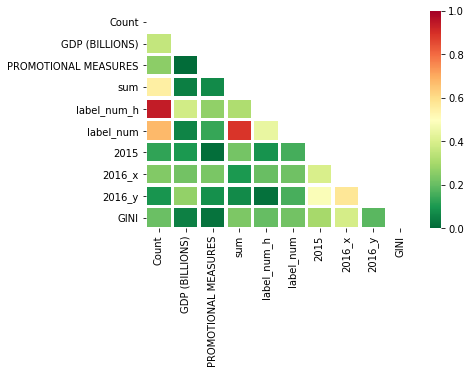

In [33]:
print("--------------- CREATE A HEATMAP ---------------")
# Create a mask to display only the lower triangle of the matrix (since it's mirrored around its 
# top-left to bottom-right diagonal).
mask = np.zeros_like(abs_corr_df)
mask[np.triu_indices_from(mask)] = True
# Create the heatmap using seaborn library. 
# List if colormaps (parameter 'cmap') is available here: http://matplotlib.org/examples/color/colormaps_reference.html
seaborn.heatmap(abs_corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=0 , mask = mask, linewidths=2.5)
 
# Show the plot we reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()

# Open Data Set Index

# Does information reliability impacts the duration of the case? 

In [207]:
df_countrydate = pd.read_excel(report_folder + 'Countries_count.xlsx') 

In [238]:
df_countrydate[df_countrydate['date_commenced']=='Mid-'] = 2002

In [237]:
df_countrydate['duration'] =  df_countrydate['date_finished'] - pd.to_numeric(df_countrydate['date_commenced'])

In [251]:
group_country = df_countrydate.groupby('Country')

In [253]:
grouped_countrydate = group_country['duration'].aggregate(['mean','sum'])

In [254]:
grouped_countrydate = grouped_countrydate.reset_index()

In [257]:
df_countrydate_rel = pd.merge(left = grouped_countrydate, right = pd_indicators_rel, left_on = 'Country', right_on = 'Country Name')

In [258]:
df_countrydate_rel.rename(columns={2016:'Reliability2016'}, inplace = True)


In [260]:
df_countrydate_rel_an = df_countrydate_rel[['Country','mean', 'sum','Reliability2016']]

In [264]:
df_countrydate_rel_an.rename(columns= {'mean': 'mean_duration', 'sum': 'sum_duration'}, inplace = True)

In [261]:
calculate_pvalues(df_countrydate_rel_an) #very bad :( 

,mean,sum,Reliability2016
mean,0,0.1021,0.9792
sum,0.1021,0,0.7361
Reliability2016,0.9792,0.7361,0


In [262]:
corr_df = df_countrydate_rel_an.corr(method='pearson')
print("--------------- CORRELATIONS ---------------")
corr_df.head(3)

--------------- CORRELATIONS ---------------


,mean,sum,Reliability2016
mean,1.000000,0.177494,-0.002870
sum,0.177494,1.000000,0.037001
Reliability2016,-0.002870,0.037001,1.000000


## Add security breaches

In [273]:
df_breaches = pd.read_excel(report_folder + "Breach-index.xlsx")

In [279]:
df_final_w_breaches = df_freedom_gdp_freind.iloc[:,[5, 4, 8,10, 20,18, 23, 25, 27, 29, 31, 32]]

In [276]:
df_countrydate_rel_breach_an = pd.merge(left = df_countrydate_rel_an, right = df_breaches, on = 'Country')

In [281]:
df_countrydate_rel_breach_an1 = pd.merge(left = df_final_w_breaches, right = df_countrydate_rel_breach_an, on = 'Country')

In [283]:
df_countrydate_rel_breach_an1.head(3)

,Country,Count,GDP (BILLIONS),PROMOTIONAL MEASURES,sum,label_num_h,label_num,corrupt perception,corporate transparency,Reliability of transparency,disclosure_index,GINI,mean_duration,sum_duration,Reliability2016,Breaches_2017
0,Albania,2,13.4,10,969,0,0,36,7.0,0.0,9.0,29.0,8.000000,16.0,0.0,0
1,Algeria,3,227.8,0,845,1,1,36,2.0,5.0,4.0,35.3,8.333333,25.0,5.0,0
2,Argentina,18,536.2,11,82,2,3,32,7.0,5.0,7.0,42.7,5.055556,91.0,5.0,1


In [284]:
writer = pd.ExcelWriter(report_folder + 'df_countrydate_rel_breach_an1.xlsx')
df_countrydate_rel_breach_an1.to_excel (writer)
writer.save()

In [ ]:
df_countrydate_rel_breach_an1 = pd.read_excel(report_folder + 'df_countrydate_rel_breach_an1.xlsx')

In [285]:
calculate_pvalues(df_countrydate_rel_breach_an1)

,Count,GDP (BILLIONS),PROMOTIONAL MEASURES,sum,label_num_h,label_num,corrupt perception,corporate transparency,Reliability of transparency,disclosure_index,GINI,mean_duration,sum_duration,Reliability2016,Breaches_2017
Count,0,0.0019,0.0205,0,0,0,0.242,0.0323,0.4202,0.0265,0.0749,0.5321,0,0.4202,0.6082
GDP (BILLIONS),0.0019,0,0.9448,0.6369,0.2897,0.6397,0.3425,0.0608,0.0192,0.1285,0.6633,0.0739,0.0048,0.0192,0
PROMOTIONAL MEASURES,0.0205,0.9448,0,0.4099,0.0452,0.1818,0.9651,0.079,0.632,0.8664,0.7609,0.3276,0.0171,0.632,0.2672
sum,0,0.6369,0.4099,0,0,0,0.0471,0.3126,0.4427,0.2871,0.0457,0.0165,0,0.4427,0.1245
label_num_h,0,0.2897,0.0452,0,0,0,0.1885,0.0339,0.3268,0.0966,0.2007,0.1068,0,0.3268,0.2581
label_num,0,0.6397,0.1818,0,0,0,0.1624,0.0502,0.1392,0.0779,0.0619,0.1999,0,0.1392,0.2911
corrupt perception,0.242,0.3425,0.9651,0.0471,0.1885,0.1624,0,0.0009,0,0.2781,0.008,0.8022,0.2656,0,0.0148
corporate transparency,0.0323,0.0608,0.079,0.3126,0.0339,0.0502,0.0009,0,0,0.0026,0.0004,0.2621,0.0152,0,0.8531
Reliability of transparency,0.4202,0.0192,0.632,0.4427,0.3268,0.1392,0,0,0,0.3608,0.1163,0.4659,0.3254,0,0.2392
disclosure_index,0.0265,0.1285,0.8664,0.2871,0.0966,0.0779,0.2781,0.0026,0.3608,0,0.1877,0.6087,0.0166,0.3608,0.605


In [286]:
corr_df = df_countrydate_rel_breach_an1.corr(method='pearson')
print("--------------- CORRELATIONS ---------------")
corr_df.head(len(df_countrydate_rel_breach_an1))

--------------- CORRELATIONS ---------------


,Count,GDP (BILLIONS),PROMOTIONAL MEASURES,sum,label_num_h,label_num,corrupt perception,corporate transparency,Reliability of transparency,disclosure_index,GINI,mean_duration,sum_duration,Reliability2016,Breaches_2017
Count,1.000000,0.355255,0.270428,-0.551167,0.739385,0.674832,-0.131057,0.248997,0.098424,0.255426,0.207678,0.072200,0.986011,0.095116,-0.060109
GDP (BILLIONS),0.355255,1.000000,-0.003345,0.056230,0.123195,0.055594,-0.104690,0.221086,0.273817,0.180857,0.050826,-0.210403,0.325120,0.271757,0.824477
PROMOTIONAL MEASURES,0.270428,-0.003345,1.000000,-0.094457,0.226058,0.156707,0.016669,0.229670,0.075510,0.057571,0.033414,0.107545,0.277116,0.056590,-0.127463
sum,-0.551167,0.056230,-0.094457,1.000000,-0.811996,-0.891605,0.230770,-0.112371,-0.087514,-0.116132,-0.233265,-0.278168,-0.571965,-0.090594,0.180331
label_num_h,0.739385,0.123195,0.226058,-0.811996,1.000000,0.914758,-0.158651,0.230799,0.108476,0.175231,0.150950,0.190506,0.753384,0.115572,-0.133604
label_num,0.674832,0.055594,0.156707,-0.891605,0.914758,1.000000,-0.160468,0.224208,0.172937,0.200183,0.217927,0.150073,0.687387,0.173532,-0.124203
corrupt perception,-0.131057,-0.104690,0.016669,0.230770,-0.158651,-0.160468,1.000000,0.400648,0.489273,0.167003,-0.304511,0.021244,-0.125331,0.476767,-0.276363
corporate transparency,0.248997,0.221086,0.229670,-0.112371,0.230799,0.224208,0.400648,1.000000,0.576450,0.389091,-0.391238,0.116547,0.279257,0.563356,0.024738
Reliability of transparency,0.098424,0.273817,0.075510,-0.087514,0.108476,0.172937,0.489273,0.576450,1.000000,0.144745,-0.184512,0.077666,0.118291,1.000000,0.139164
disclosure_index,0.255426,0.180857,0.057571,-0.116132,0.175231,0.200183,0.167003,0.389091,0.144745,1.000000,-0.153062,0.043711,0.272990,0.107752,0.062757


## Analysis without the US 

In [75]:
df_final_wo_us = df_freedom_gdp_freind.iloc[:,[0, 1,2, 3, 5,6,7,8,9,10,11,12,13,14, 15]]

In [79]:
df_final_wo_us = df_final_wo_us.drop(df_final_wo_us[df_final_wo_us['Country'] == 'United States'].index)

In [80]:
df_final_wo_us = df_final_wo_us.iloc[:,[1,2, 3, 4,5,6,7,8,9,10,11,12,13, 14]]

In [82]:
calculate_pvalues(df_final_wo_us)

,Count,GDP (BILLIONS),PROMOTIONAL MEASURES,label_num_h,label_num,corrupt perception,corporate transparency,Reliability of transparency,disclosure_index,GINI,mean_duration,sum_duration,Reliability2016,Breaches_2017
Count,0,0,0.0243,0,0,0.1661,0.0326,0.3808,0.0252,0.069,0.5855,0,0.3808,0.8803
GDP (BILLIONS),0,0,0.1202,0.0004,0.0119,0.0405,0.0016,0.0124,0.0433,0.87,0.247,0,0.0124,0.0146
PROMOTIONAL MEASURES,0.0243,0.1202,0,0.0621,0.276,0.6804,0.0755,0.5243,0.8188,0.6921,0.422,0.0208,0.5243,0.2007
label_num_h,0,0.0004,0.0621,0,0,0.0824,0.0323,0.2558,0.0845,0.17,0.1464,0,0.2558,0.6709
label_num,0,0.0119,0.276,0,0,0.0186,0.1986,0.234,0.1754,0.0038,0.0714,0,0.234,0.9775
corrupt perception,0.1661,0.0405,0.6804,0.0824,0.0186,0,0.0004,0,0.205,0.0106,0.871,0.1793,0,0.0029
corporate transparency,0.0326,0.0016,0.0755,0.0323,0.1986,0.0004,0,0,0.0028,0.0004,0.2516,0.0153,0,0.1161
Reliability of transparency,0.3808,0.0124,0.5243,0.2558,0.234,0,0,0,0.3899,0.0962,0.3585,0.2881,0,0.0776
disclosure_index,0.0252,0.0433,0.8188,0.0845,0.1754,0.205,0.0028,0.3899,0,0.1778,0.5579,0.0156,0.3899,0.0787
GINI,0.069,0.87,0.6921,0.17,0.0038,0.0106,0.0004,0.0962,0.1778,0,0.468,0.1404,0.0962,0.3801


In [83]:
corr_df = df_final_wo_us.corr(method='pearson')
print("--------------- CORRELATIONS ---------------")
corr_df.head(len(df_final_wo_us))

--------------- CORRELATIONS ---------------


,Count,GDP (BILLIONS),PROMOTIONAL MEASURES,label_num_h,label_num,corrupt perception,corporate transparency,Reliability of transparency,disclosure_index,GINI,mean_duration,sum_duration,Reliability2016,Breaches_2017
Count,1.000000,0.704973,0.265105,0.739134,0.705479,-0.156000,0.250466,0.107430,0.259514,0.213361,0.063323,0.985973,0.104105,0.018694
GDP (BILLIONS),0.704973,1.000000,0.187385,0.403899,0.293767,0.243881,0.361438,0.294232,0.239122,-0.020207,-0.138962,0.661961,0.291465,0.285522
PROMOTIONAL MEASURES,0.265105,0.187385,1.000000,0.212106,0.131976,-0.024012,0.233980,0.094618,0.065412,0.044244,0.087799,0.271102,0.075717,0.153513
label_num_h,0.739134,0.403899,0.212106,1.000000,0.792204,-0.207838,0.234949,0.127643,0.184046,0.162859,0.173127,0.752741,0.134715,-0.051461
label_num,0.705479,0.293767,0.131976,0.792204,1.000000,-0.265472,0.154820,0.143783,0.161985,0.333966,0.210510,0.721224,0.141033,0.004110
corrupt perception,-0.156000,0.243881,-0.024012,-0.207838,-0.265472,1.000000,0.423856,0.555856,0.191110,-0.295942,-0.027276,-0.152034,0.544357,0.342890
corporate transparency,0.250466,0.361438,0.233980,0.234949,0.154820,0.423856,1.000000,0.579339,0.388844,-0.393650,0.120685,0.281005,0.566442,0.186246
Reliability of transparency,0.107430,0.294232,0.094618,0.127643,0.143783,0.555856,0.579339,1.000000,0.139246,-0.196618,0.100616,0.128398,1.000000,0.209268
disclosure_index,0.259514,0.239122,0.065412,0.184046,0.161985,0.191110,0.388844,0.139246,1.000000,-0.157794,0.052999,0.277592,0.102124,0.205684
GINI,0.213361,-0.020207,0.044244,0.162859,0.333966,-0.295942,-0.393650,-0.196618,-0.157794,1.000000,-0.085308,0.173681,-0.196203,-0.104644


## Does duration correlate with anything at all?

In [ ]:
df_freedom_gdp_freind_an1 = df_freedom_gdp_freind.iloc[:,[5, 4, 8,10, 20,18, 23, 25, 27, 29, 31, 32]]

In [271]:
df_final_countrydate_rel = pd.merge(left = df_freedom_gdp_freind_an1, right = df_countrydate_rel_an, on = 'Country' )

In [272]:
calculate_pvalues(df_final_countrydate_rel)

,Count,GDP (BILLIONS),PROMOTIONAL MEASURES,sum,label_num_h,label_num,corrupt perception,corporate transparency,Reliability of transparency,disclosure_index,GINI,mean_duration,sum_duration,Reliability2016
Count,0,0.0019,0.0205,0,0,0,0.242,0.0323,0.4202,0.0265,0.0749,0.5321,0,0.4202
GDP (BILLIONS),0.0019,0,0.9448,0.6369,0.2897,0.6397,0.3425,0.0608,0.0192,0.1285,0.6633,0.0739,0.0048,0.0192
PROMOTIONAL MEASURES,0.0205,0.9448,0,0.4099,0.0452,0.1818,0.9651,0.079,0.632,0.8664,0.7609,0.3276,0.0171,0.632
sum,0,0.6369,0.4099,0,0,0,0.0471,0.3126,0.4427,0.2871,0.0457,0.0165,0,0.4427
label_num_h,0,0.2897,0.0452,0,0,0,0.1885,0.0339,0.3268,0.0966,0.2007,0.1068,0,0.3268
label_num,0,0.6397,0.1818,0,0,0,0.1624,0.0502,0.1392,0.0779,0.0619,0.1999,0,0.1392
corrupt perception,0.242,0.3425,0.9651,0.0471,0.1885,0.1624,0,0.0009,0,0.2781,0.008,0.8022,0.2656,0
corporate transparency,0.0323,0.0608,0.079,0.3126,0.0339,0.0502,0.0009,0,0,0.0026,0.0004,0.2621,0.0152,0
Reliability of transparency,0.4202,0.0192,0.632,0.4427,0.3268,0.1392,0,0,0,0.3608,0.1163,0.4659,0.3254,0
disclosure_index,0.0265,0.1285,0.8664,0.2871,0.0966,0.0779,0.2781,0.0026,0.3608,0,0.1877,0.6087,0.0166,0.3608


# Preparation

In [44]:
# split by ; and strip \n
country_list = find_between(keyfacts, '\nCountry.\n  \n','\nDate' ).replace('\n','').strip() 

In [34]:
date_filed = find_between(keyfacts,'\nDate Filed.\n', '\nCountry.\n  \n' ).replace('\n','').strip()

In [50]:
date_of_conduct = find_between(keyfacts,'Date of Conduct.\n  \n', '\nAmount of the Value' ).replace('\n','').strip()

In [52]:
amount = find_between(keyfacts,'\nAmount of the Value', '\nAmount of Business Related' ).replace('\n','').strip()

In [54]:
total_sanction = find_between(keyfacts,'\nTotal Sanction.\n', '\nCompliance Monitor' ).replace('\n','').strip()

In [55]:
fcpa_provision = find_between(keyfacts,'\nFCPA Statutory Provision', 'nOther Statutory Provision' ).replace('\n','').strip()

In [40]:
date_filed.replace('\n','').strip().strip('.')

'November 29, 2017'

In [ ]:
startTime = time.perf_counter()
row_list = []


In [78]:
a1 = list(zip(['a','b','c'],[ 1,2,3]))

In [79]:
dict((k[0],k[1]) for k in a1)

{'a': 1, 'b': 2, 'c': 3}

In [66]:
df.append([[date_filed, country_list, date_of_conduct, amount, total_sanction, fcpa_provision]] )

,Date_filed,Countries,Date_Interval,Amount_of_Value,Total_Sanction,FCPA_Statutory_Provision,0,1,2,3,4,5
0,NaN,NaN,NaN,NaN,NaN,NaN,"\nNovember 29, 2017.\n",Brazil; Angola; Equatorial Guinea; Kazakhstan;...,1996 2012.,. At least $180 million.,"$238,000,000.",


In [ ]:
df3 = pandas.DataFrame(row_list, columns=['A','B','C','D','E'])
print('Elapsed time: {:6.3f} seconds for {:d} rows'.format(time.perf_counter() - startTime, numOfRows))

In [ ]:
#how to get all of the necessary parts together?

In [45]:
split_up(country_list)

['Brazil', ' Angola', ' Equatorial Guinea', ' Kazakhstan', ' Iraq.']